# Additional Visualizations for Market Basket Analysis

This notebook contains additional visualizations for the market basket analysis project. These visualizations help in understanding the patterns, relationships, and insights from the association rules generated by the mining algorithms.

## Setting Up the Environment

First, let's import the necessary libraries and set up our environment.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.frequent_patterns import association_rules

# Ensure directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Helper functions
def load_csv_file(file_path):
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

def convert_itemsets_str(df):
    """Convert string representation of itemsets back to lists."""
    if 'itemsets' in df.columns:
        df['itemsets'] = df['itemsets'].apply(lambda x: x.strip('[]').replace("'", "").split(', ') if isinstance(x, str) else x)
    if 'antecedents' in df.columns:
        df['antecedents'] = df['antecedents'].apply(lambda x: x.strip('[]').replace("'", "").split(', ') if isinstance(x, str) else x)
    if 'consequents' in df.columns:
        df['consequents'] = df['consequents'].apply(lambda x: x.strip('[]').replace("'", "").split(', ') if isinstance(x, str) else x)
    return df

In [2]:
# Load the association rules
try:
    apriori_rules = load_csv_file('output/apriori_rules.csv')
    apriori_rules = convert_itemsets_str(apriori_rules)
    print(f"Loaded {len(apriori_rules)} association rules from Apriori")

    # Display the first few rules
    apriori_rules.head()
except FileNotFoundError:
    print("Apriori rules file not found. Run the mining notebook first.")

Loaded 29 association rules from Apriori


## 1. Association Rule Network Visualization

This visualization creates a directed graph (network) representing the association rules. Each node is an item, and directed edges represent the rules. The thickness of an edge corresponds to the lift value of the rule.

**Interpretation**: 
- Nodes represent individual items
- Directed edges represent rules (antecedent → consequent)
- Edge thickness indicates the lift value
- Node colors differentiate between items that appear as antecedents (blue) and consequents (green)

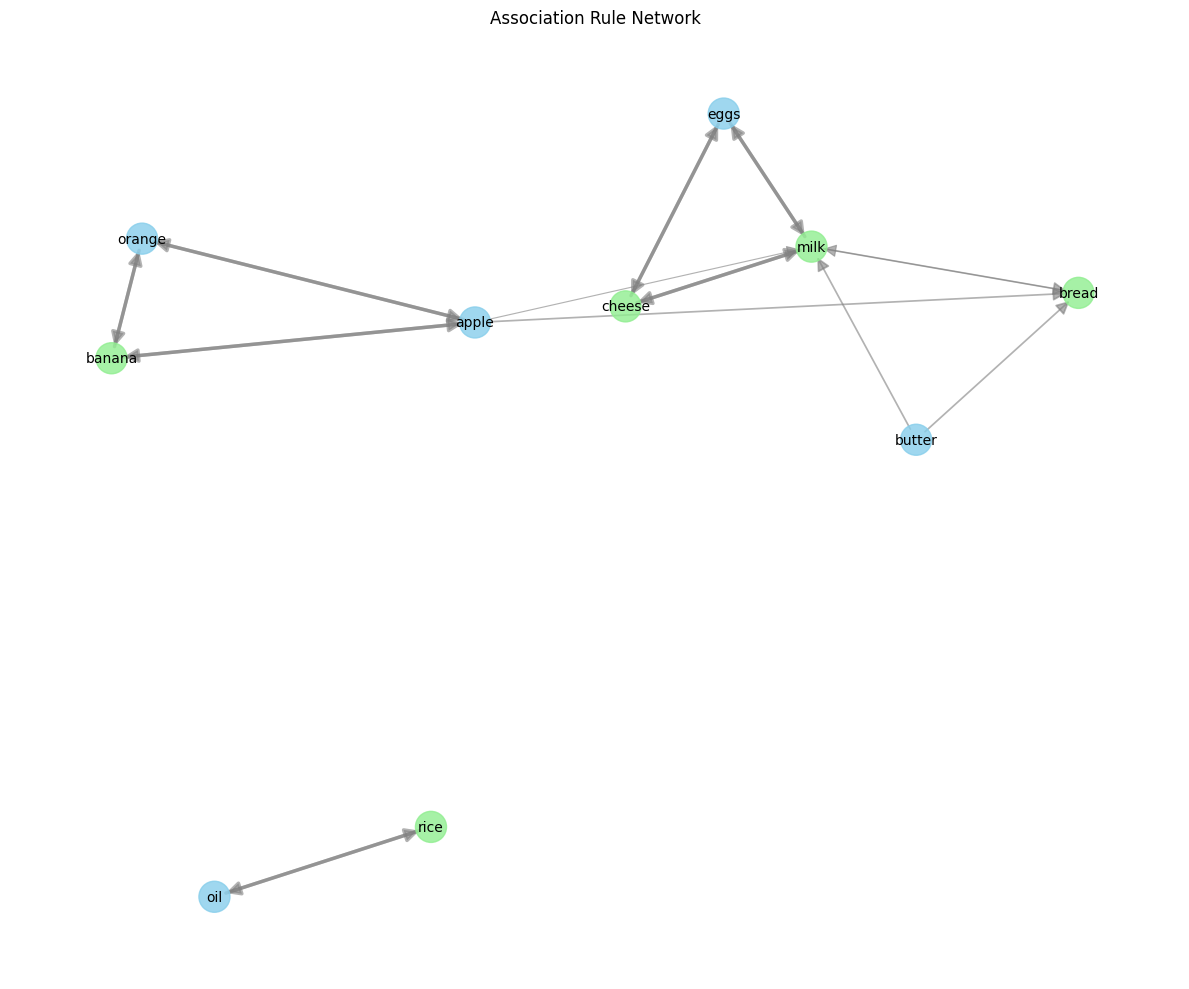

Association rule network visualization saved to '../figures/association_rule_network.png'


In [3]:
def create_association_rule_network(rules_df, min_lift=1.0):
    """Create a network visualization of association rules."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create network.")
        return

    G = nx.DiGraph()

    # Add nodes and edges from rules
    for _, rule in rules_df.iterrows():
        if rule['lift'] >= min_lift:
            antecedents = rule['antecedents']
            consequents = rule['consequents']

            # Handle both single items and itemsets
            for a in antecedents:
                for c in consequents:
                    G.add_node(a, type='antecedent')
                    G.add_node(c, type='consequent')
                    G.add_edge(a, c, lift=rule['lift'],
                               confidence=rule['confidence'],
                               support=rule['support'])

    # Draw the network
    plt.figure(figsize=(12, 10))

    # Node positions and colors
    pos = nx.spring_layout(G, k=0.8)
    node_colors = ['skyblue' if G.nodes[n].get('type') == 'antecedent'
                  else 'lightgreen' for n in G.nodes()]

    # Edge weights based on lift
    edge_weights = [G[u][v]['lift'] * 0.5 for u, v in G.edges()]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_weights,
                          edge_color='gray', alpha=0.6,
                          arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title('Association Rule Network')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/association_rule_network.png', dpi=300)
    plt.show()
    print("Association rule network visualization saved to '../figures/association_rule_network.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_association_rule_network(apriori_rules, min_lift=1.0)

## 2. Lift Matrix Heatmap

This visualization creates a heatmap showing the lift values between different items. It helps to identify which item pairs have stronger relationships.

**Interpretation**:
- The x-axis represents consequent items
- The y-axis represents antecedent items
- Color intensity indicates the lift value (darker colors = higher lift)
- A high lift value in a cell indicates a strong association between that row item (antecedent) and column item (consequent)

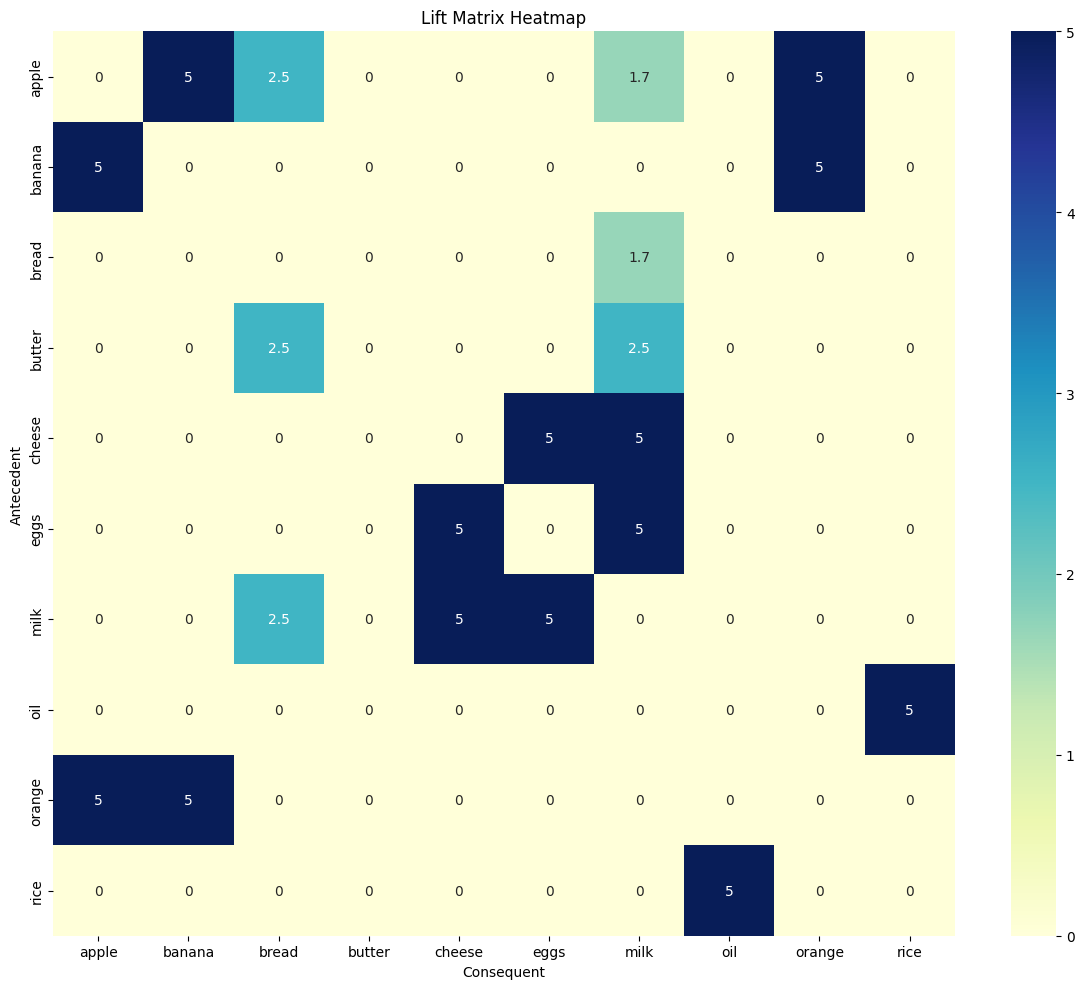

Lift matrix heatmap saved to '../figures/lift_matrix_heatmap.png'


In [4]:
def create_lift_matrix(rules_df):
    """Create a heatmap of the lift values between items."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create lift matrix.")
        return

    # Extract unique items from rules
    items = set()
    for _, rule in rules_df.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']
        items.update(antecedents + consequents)

    items = sorted(list(items))
    n_items = len(items)

    # Create a matrix of lift values
    lift_matrix = np.zeros((n_items, n_items))

    for _, rule in rules_df.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']

        for a in antecedents:
            for c in consequents:
                if a in items and c in items:
                    i = items.index(a)
                    j = items.index(c)
                    lift_matrix[i, j] = rule['lift']

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(lift_matrix, annot=True, cmap='YlGnBu',
               xticklabels=items, yticklabels=items)
    plt.title('Lift Matrix Heatmap')
    plt.xlabel('Consequent')
    plt.ylabel('Antecedent')
    plt.tight_layout()
    plt.savefig('../figures/lift_matrix_heatmap.png', dpi=300)
    plt.show()
    print("Lift matrix heatmap saved to '../figures/lift_matrix_heatmap.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_lift_matrix(apriori_rules)

## 3. 3D Rule Visualization

This visualization creates a 3D scatter plot showing the relationship between support, confidence, and lift metrics for all rules.

**Interpretation**:
- Each point represents an association rule
- The x-axis represents support
- The y-axis represents confidence
- The z-axis represents lift
- Color intensity also represents lift value
- Points in the upper-right corner with warmer colors are typically the most interesting rules (high support, confidence, and lift)

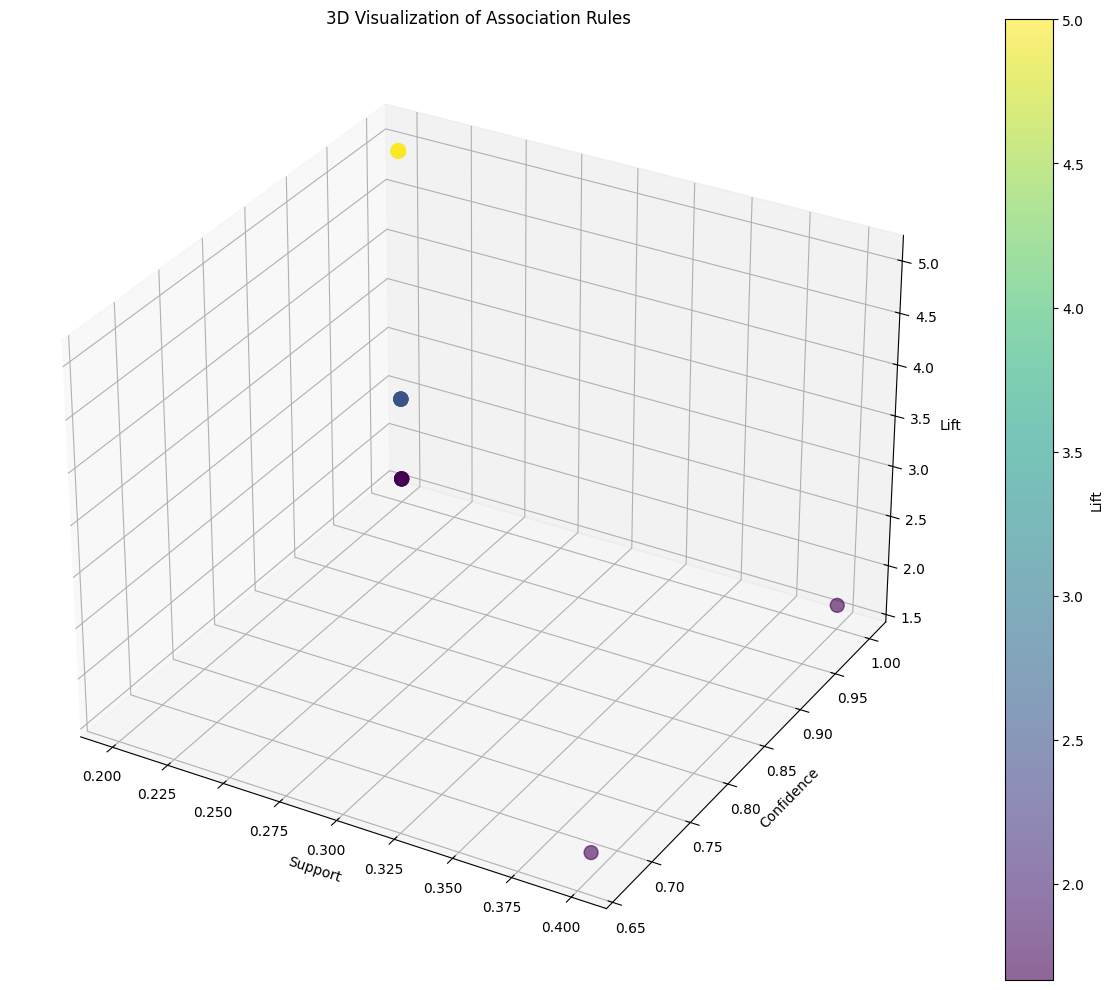

3D rule visualization saved to '../figures/3d_rule_plot.png'


In [5]:
def create_3d_rule_plot(rules_df):
    """Create a 3D scatter plot of rule metrics."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create 3D plot.")
        return

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract metrics
    support = rules_df['support'].values
    confidence = rules_df['confidence'].values
    lift = rules_df['lift'].values

    # Create scatter plot
    scatter = ax.scatter(support, confidence, lift,
                        c=lift, cmap='viridis',
                        s=100, alpha=0.6)

    # Add colorbar and labels
    plt.colorbar(scatter, label='Lift')
    ax.set_xlabel('Support')
    ax.set_ylabel('Confidence')
    ax.set_zlabel('Lift')
    ax.set_title('3D Visualization of Association Rules')

    # Save the figure
    plt.tight_layout()
    plt.savefig('../figures/3d_rule_plot.png', dpi=300)
    plt.show()
    print("3D rule visualization saved to '../figures/3d_rule_plot.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_3d_rule_plot(apriori_rules)

## 4. Bubble Chart of Rule Metrics

This visualization creates a bubble chart where the position and size of each bubble represent different rule metrics.

**Interpretation**:
- Each bubble represents an association rule
- The x-axis represents support
- The y-axis represents confidence
- The bubble size represents lift
- Color intensity also represents lift value
- Larger, darker bubbles with higher positions are typically the most interesting rules

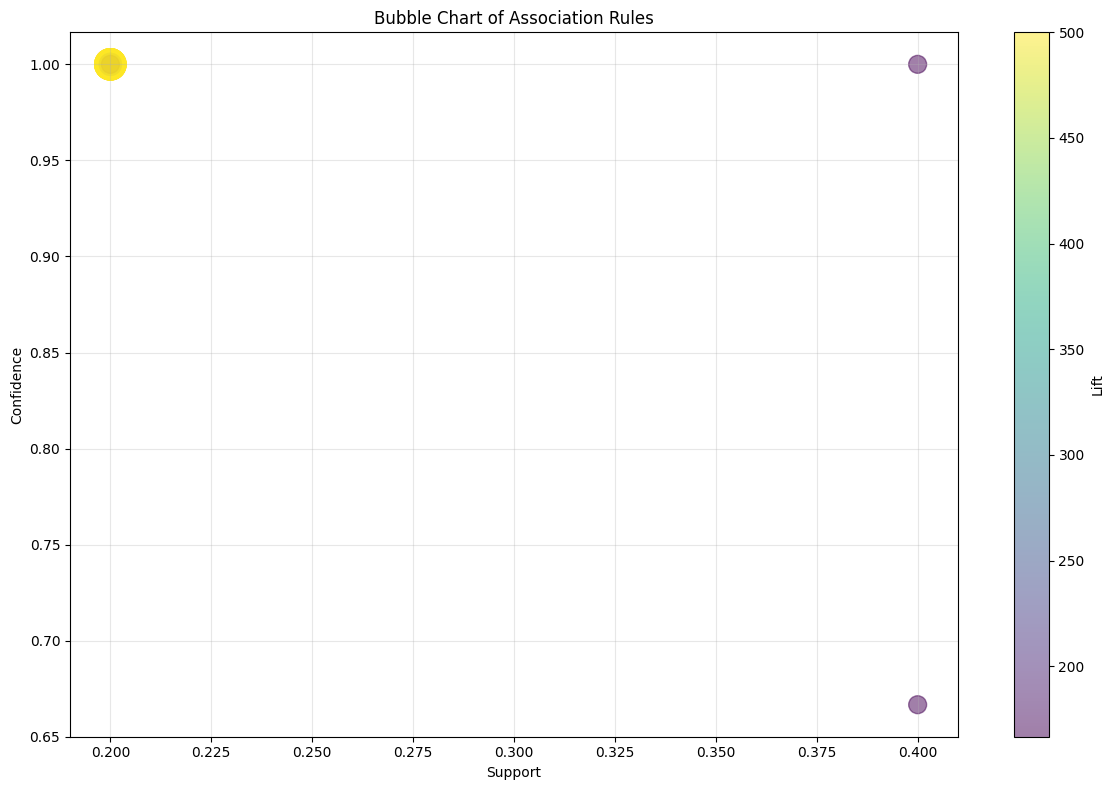

Bubble chart saved to '../figures/rule_bubble_chart.png'


In [6]:
def create_bubble_chart(rules_df):
    """Create a bubble chart of rule metrics."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create bubble chart.")
        return

    plt.figure(figsize=(12, 8))

    # Extract metrics
    x = rules_df['support'].values
    y = rules_df['confidence'].values
    size = rules_df['lift'].values * 100

    # Create bubble chart
    plt.scatter(x, y, s=size, alpha=0.5, c=size, cmap='viridis')

    plt.colorbar(label='Lift')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Bubble Chart of Association Rules')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figures/rule_bubble_chart.png', dpi=300)
    plt.show()
    print("Bubble chart saved to '../figures/rule_bubble_chart.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_bubble_chart(apriori_rules)

## 5. Parallel Coordinates Plot

This visualization creates a parallel coordinates plot showing how different metrics relate to each other across rules.

**Interpretation**:
- Each colored line represents a rule
- Each vertical axis represents a different metric
- Lines are colored by antecedent length
- Patterns in the line paths indicate relationships between metrics
- Parallel lines indicate similar rules, crossing lines indicate trade-offs between metrics

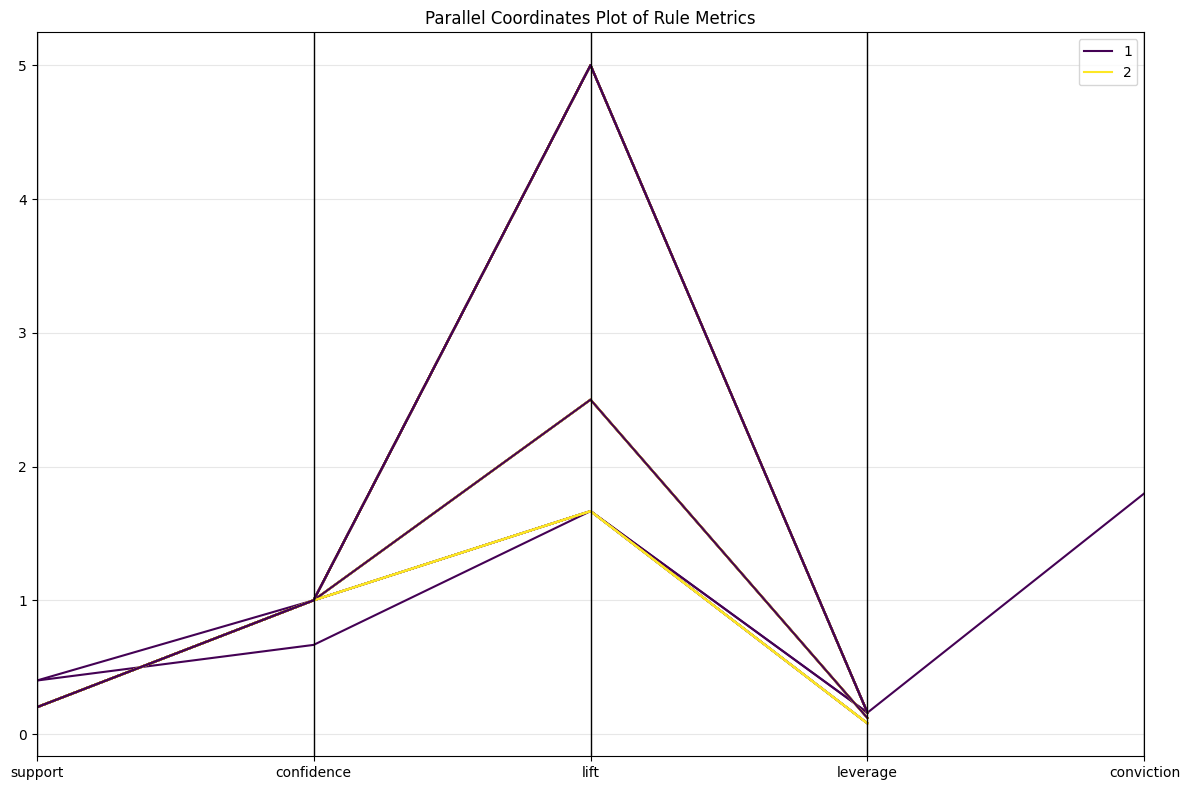

Parallel coordinates plot saved to '../figures/parallel_coordinates.png'


In [7]:
def create_parallel_coordinates(rules_df):
    """Create a parallel coordinates plot of rule metrics."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create parallel coordinates plot.")
        return

    # Create a copy of the rules with only numerical columns
    plot_df = rules_df[['support', 'confidence', 'lift', 'leverage', 'conviction']].copy()

    # Add a column for coloring
    plot_df['antecedent_len'] = rules_df['antecedents'].apply(len)

    plt.figure(figsize=(12, 8))
    pd.plotting.parallel_coordinates(plot_df, 'antecedent_len', colormap='viridis')
    plt.title('Parallel Coordinates Plot of Rule Metrics')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figures/parallel_coordinates.png', dpi=300)
    plt.show()
    print("Parallel coordinates plot saved to '../figures/parallel_coordinates.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_parallel_coordinates(apriori_rules)

## 6. Radar Chart for Top Rules

This visualization creates a radar chart (spider chart) comparing different metrics for the top rules.

**Interpretation**:
- Each colored polygon represents one of the top rules
- Each axis represents a different metric
- The distance from the center indicates the value of that metric
- Larger polygons generally indicate stronger rules overall
- The shape of each polygon shows the balance between metrics

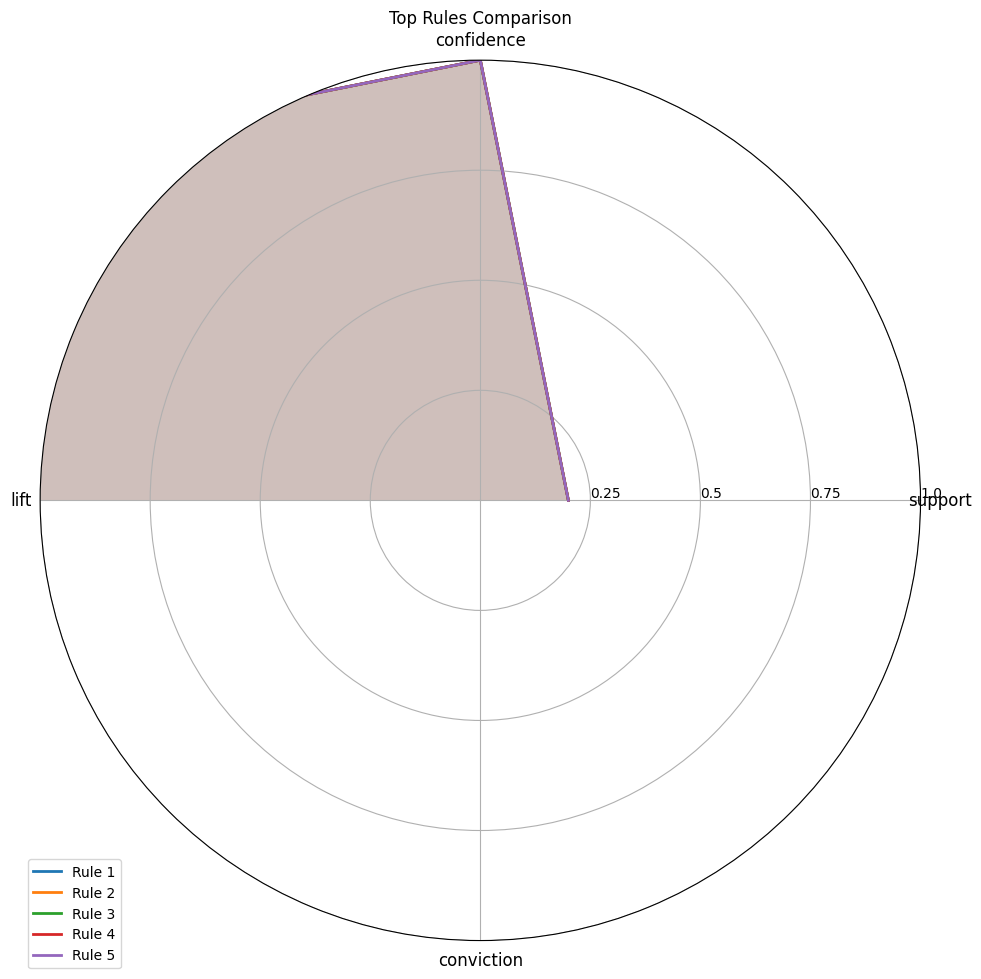

Radar chart saved to '../figures/radar_chart.png'


In [8]:
def create_radar_chart(rules_df, top_n=5):
    """Create a radar chart for top rules based on lift."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create radar chart.")
        return

    # Get top N rules by lift
    top_rules = rules_df.nlargest(top_n, 'lift')

    # Extract rule metrics
    metrics = ['support', 'confidence', 'lift', 'conviction']

    # Create radar chart
    fig = plt.figure(figsize=(10, 10))

    # Number of variables
    categories = metrics
    N = len(categories)

    # Create angle for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axis per variable + labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw y-labels (0-100)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], size=10)
    plt.ylim(0, 1)

    # Plot each rule
    for i, (_, rule) in enumerate(top_rules.iterrows()):
        values = [rule[metric] for metric in metrics]
        values += values[:1]  # Close the loop

        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Rule {i+1}")
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Top Rules Comparison')

    plt.tight_layout()
    plt.savefig('../figures/radar_chart.png', dpi=300)
    plt.show()
    print("Radar chart saved to '../figures/radar_chart.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_radar_chart(apriori_rules, top_n=5)

## 7. Antecedent Distribution Pie Chart

This visualization creates a pie chart showing the distribution of items appearing in rule antecedents.

**Interpretation**:
- Each slice represents an item that appears in rule antecedents
- The size of each slice is proportional to the frequency of that item in antecedents
- Items with larger slices are more common in the "if" part of rules
- This helps identify which items most often lead to purchasing other items

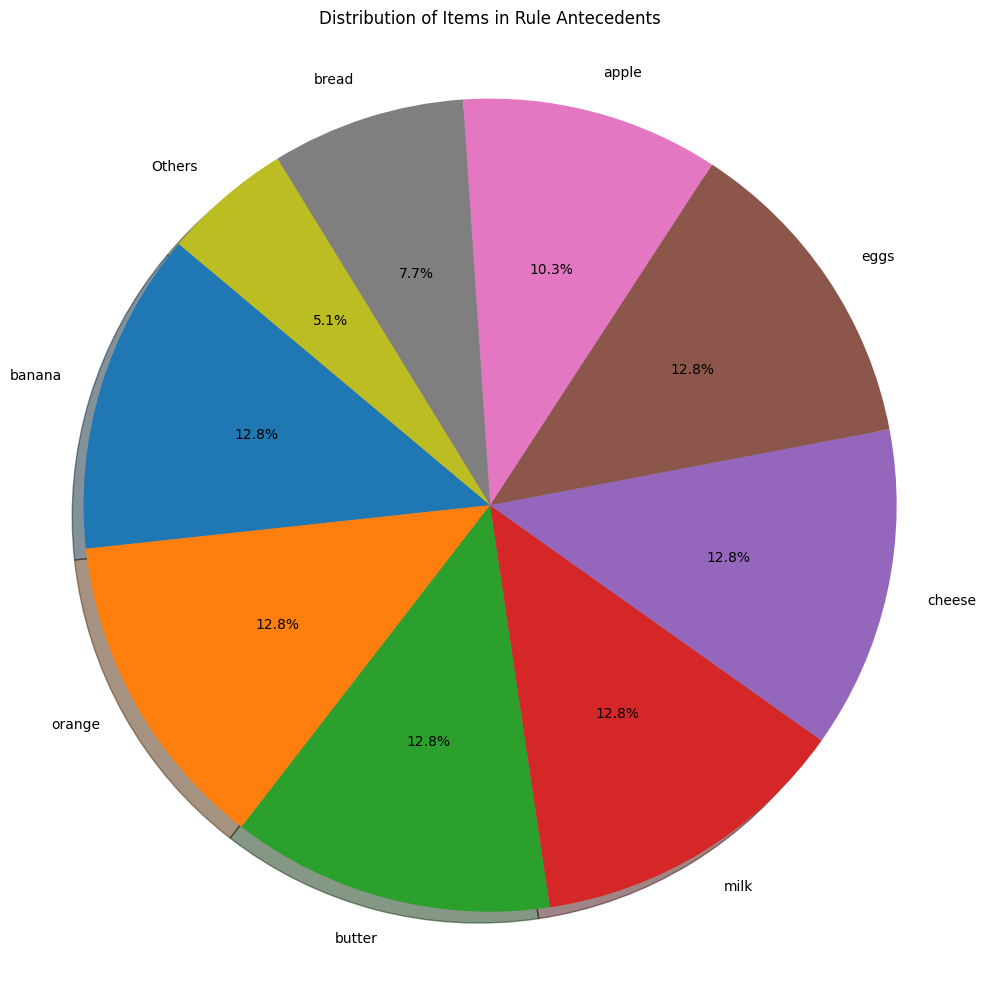

Antecedent distribution pie chart saved to '../figures/antecedent_distribution.png'


In [9]:
def create_antecedent_pie_chart(rules_df):
    """Create a pie chart showing distribution of antecedent items."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create pie chart.")
        return

    # Count occurrences of each item in antecedents
    antecedent_items = {}
    for _, rule in rules_df.iterrows():
        for item in rule['antecedents']:
            if item in antecedent_items:
                antecedent_items[item] += 1
            else:
                antecedent_items[item] = 1

    # Sort items by frequency
    sorted_items = sorted(antecedent_items.items(), key=lambda x: x[1], reverse=True)

    # Take top items for readability
    top_n = 8
    labels = [item[0] for item in sorted_items[:top_n]]
    sizes = [item[1] for item in sorted_items[:top_n]]

    # Add "Others" category if needed
    if len(sorted_items) > top_n:
        labels.append('Others')
        sizes.append(sum(item[1] for item in sorted_items[top_n:]))

    # Create pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Distribution of Items in Rule Antecedents')

    plt.tight_layout()
    plt.savefig('../figures/antecedent_distribution.png', dpi=300)
    plt.show()
    print("Antecedent distribution pie chart saved to '../figures/antecedent_distribution.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_antecedent_pie_chart(apriori_rules)

## 8. Confidence Treemap

This visualization creates a treemap showing the confidence values of the top rules. Treemaps are great for displaying hierarchical data with rectangles sized according to a value.

**Interpretation**:
- Each rectangle represents a rule
- The size of the rectangle is proportional to the confidence of the rule
- Color intensity also represents confidence
- Larger, darker rectangles indicate rules with higher confidence
- The treemap provides an intuitive way to compare many rules at once

Note: This visualization requires the `squarify` package. You can install it with `pip install squarify`.

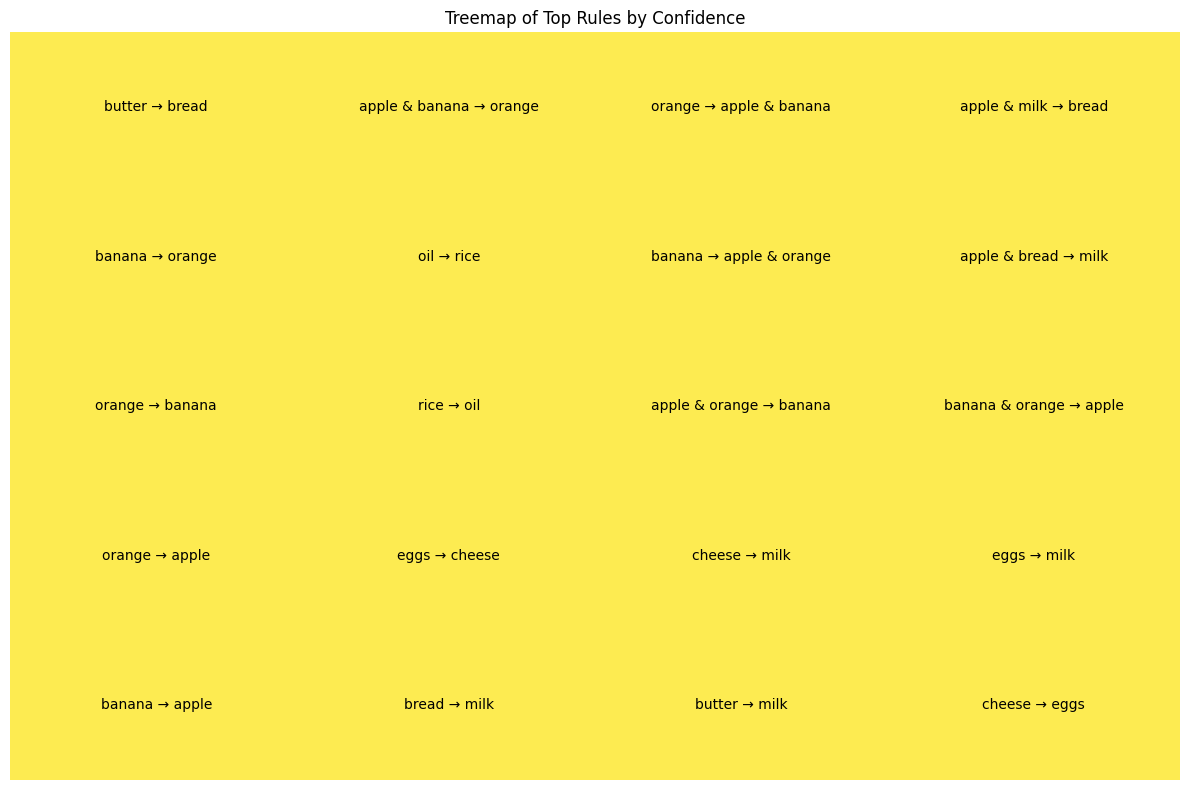

Confidence treemap saved to '../figures/confidence_treemap.png'


In [3]:
def create_confidence_treemap(rules_df, top_n=20):
    """Create a treemap visualization of rule confidence."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create treemap.")
        return

    try:
        import squarify  # You may need to install this package

        # Get top rules by confidence
        top_rules = rules_df.nlargest(top_n, 'confidence')

        # Create rule labels
        rule_labels = []
        for _, rule in top_rules.iterrows():
            ant = ' & '.join(rule['antecedents'])
            con = ' & '.join(rule['consequents'])
            rule_labels.append(f"{ant} → {con}")

        # Get confidence values
        confidence_values = top_rules['confidence'].values

        # Create treemap
        plt.figure(figsize=(12, 8))
        squarify.plot(sizes=confidence_values, label=rule_labels, alpha=0.8, color=plt.cm.viridis(confidence_values))
        plt.axis('off')
        plt.title('Treemap of Top Rules by Confidence')

        plt.tight_layout()
        plt.savefig('../figures/confidence_treemap.png', dpi=300)
        plt.show()
        print("Confidence treemap saved to '../figures/confidence_treemap.png'")
    except ImportError:
        print("Squarify package not installed. Run 'pip install squarify' to enable treemaps.")

# Create the visualization if data is available
if apriori_rules is not None:
    create_confidence_treemap(apriori_rules)

## 9. Support vs. Lift Scatter Plot with Rule Size

This visualization creates a scatter plot showing the relationship between support and lift, with points colored by confidence and sized by the length of the rule.

**Interpretation**:
- Each point represents an association rule
- The x-axis represents support
- The y-axis represents lift
- Color represents confidence (darker = higher confidence)
- Point size represents the total number of items in the rule (antecedent + consequent)
- This helps identify rules that are both interesting (high lift) and reliable (high support)

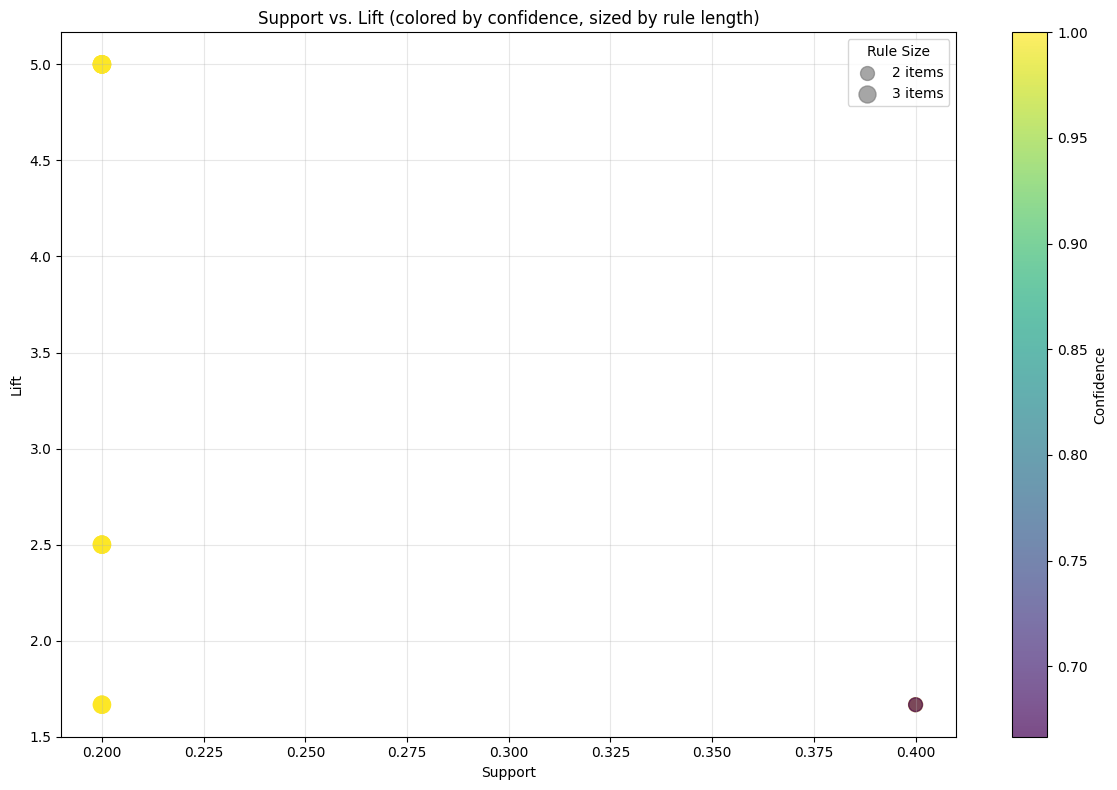

Support vs lift scatter plot saved to '../figures/support_lift_scatter.png'


In [4]:
def create_support_lift_scatter(rules_df):
    """Create a scatter plot of support vs lift with confidence as color."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create scatter plot.")
        return

    # Calculate rule size (number of items)
    rules_df['rule_size'] = rules_df.apply(lambda row: len(row['antecedents']) + len(row['consequents']), axis=1)

    plt.figure(figsize=(12, 8))

    # Create scatter plot
    scatter = plt.scatter(rules_df['support'], rules_df['lift'],
                         c=rules_df['confidence'], s=rules_df['rule_size']*50,
                         cmap='viridis', alpha=0.7)

    # Add labels and legend
    plt.xlabel('Support')
    plt.ylabel('Lift')
    plt.title('Support vs. Lift (colored by confidence, sized by rule length)')
    plt.colorbar(scatter, label='Confidence')
    plt.grid(True, alpha=0.3)

    # Add a size legend
    sizes = sorted(rules_df['rule_size'].unique())
    for size in sizes:
        plt.scatter([], [], s=size*50, c='gray', alpha=0.7, label=f'{size} items')
    plt.legend(title='Rule Size', loc='upper right')

    plt.tight_layout()
    plt.savefig('../figures/support_lift_scatter.png', dpi=300)
    plt.show()
    print("Support vs lift scatter plot saved to '../figures/support_lift_scatter.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_support_lift_scatter(apriori_rules)

## 10. Consequent Distribution Bar Chart

This visualization creates a horizontal bar chart showing the distribution of items appearing in rule consequents.

**Interpretation**:
- Each bar represents an item that appears in rule consequents
- The length of each bar is proportional to the frequency of that item in consequents
- Items with longer bars are more commonly purchased as a result of buying other items
- This helps identify which items are most frequently recommended based on the rules

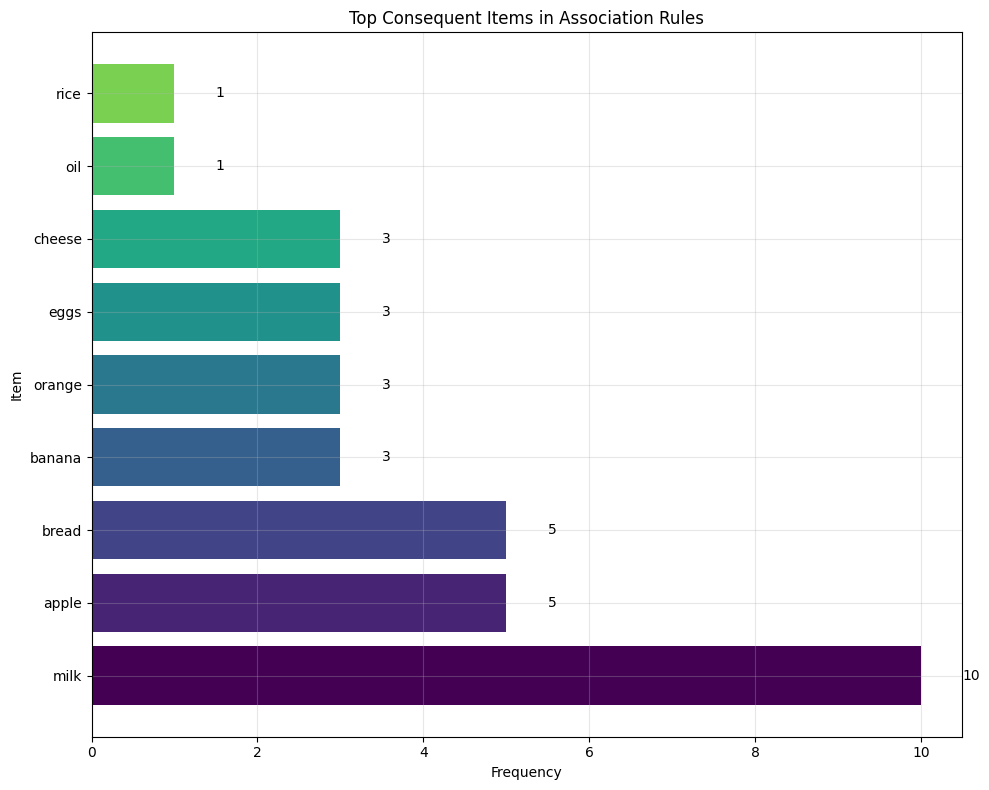

Consequent distribution bar chart saved to '../figures/consequent_distribution.png'


In [5]:
def create_consequent_bar_chart(rules_df):
    """Create a horizontal bar chart showing distribution of consequent items."""
    if rules_df is None or len(rules_df) == 0:
        print("No rules available to create bar chart.")
        return

    # Count occurrences of each item in consequents
    consequent_items = {}
    for _, rule in rules_df.iterrows():
        for item in rule['consequents']:
            if item in consequent_items:
                consequent_items[item] += 1
            else:
                consequent_items[item] = 1

    # Sort items by frequency
    sorted_items = sorted(consequent_items.items(), key=lambda x: x[1], reverse=True)

    # Take top N items for readability
    top_n = 15
    items = [item[0] for item in sorted_items[:top_n]]
    counts = [item[1] for item in sorted_items[:top_n]]

    # Create horizontal bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.barh(items, counts, color=plt.cm.viridis(np.linspace(0, 0.8, len(items))))
    plt.xlabel('Frequency')
    plt.ylabel('Item')
    plt.title('Top Consequent Items in Association Rules')
    plt.grid(True, alpha=0.3)

    # Add count labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{int(width)}', ha='left', va='center')

    plt.tight_layout()
    plt.savefig('../figures/consequent_distribution.png', dpi=300)
    plt.show()
    print("Consequent distribution bar chart saved to '../figures/consequent_distribution.png'")

# Create the visualization if data is available
if apriori_rules is not None:
    create_consequent_bar_chart(apriori_rules)

## Summary of All Visualizations

We have created 10 different visualizations for the market basket analysis:

1. **Association Rule Network** - A network graph showing relationships between items
2. **Lift Matrix Heatmap** - A heatmap showing lift values between different items
3. **3D Rule Visualization** - A 3D scatter plot of support, confidence, and lift
4. **Bubble Chart** - A bubble chart showing rule metrics with sized bubbles
5. **Parallel Coordinates Plot** - A visualization showing how metrics relate across rules
6. **Radar Chart** - A spider chart comparing different metrics for top rules
7. **Antecedent Pie Chart** - A pie chart showing distribution of antecedent items
8. **Confidence Treemap** - A treemap visualization of rule confidence
9. **Support vs. Lift Scatter** - A scatter plot with multiple dimensions encoded
10. **Consequent Bar Chart** - A horizontal bar chart of consequent item distribution

These visualizations provide different perspectives on the association rules and can help in gaining insights from the market basket analysis.